In [7]:
# pip install causal-learn

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# 데이터 로드 및 전처리
df = pd.read_csv("training_data.csv")
df = df.drop(columns=["Unnamed: 0", "label"])
data_np = df.values
labels = df.columns.tolist()

# PC 알고리즘 실행
cg = pc(data=data_np, indep_test_func=fisherz, alpha=0.1)

# networkx 그래프로 변환
G = cg.to_nx_graph()


Depth=6, working on node 12: 100%|██████████| 13/13 [00:00<00:00, 1038.33it/s]


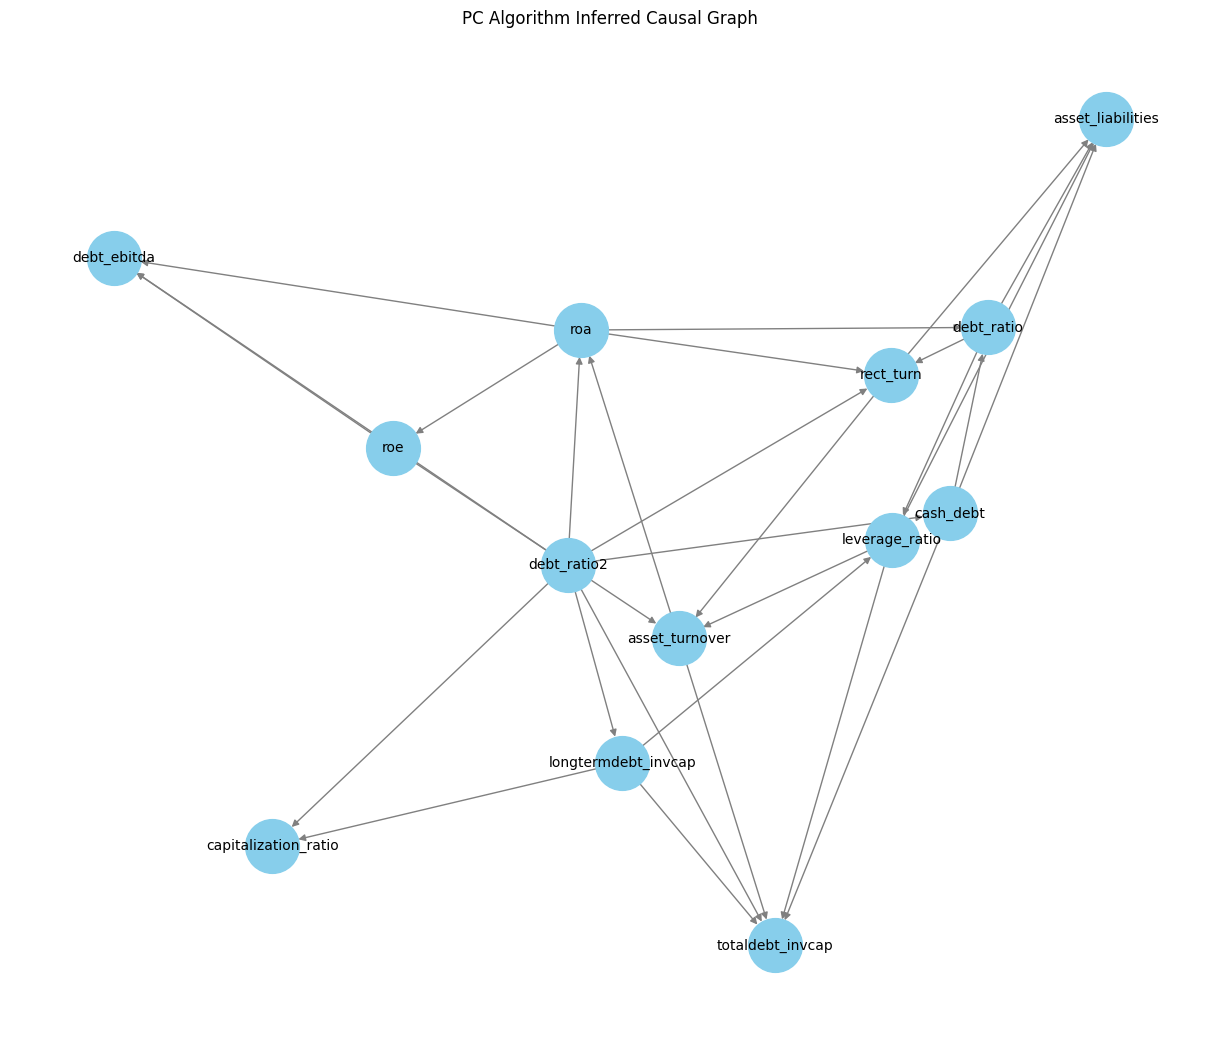

In [9]:
# 3. 네트워크 그래프 객체 수동 생성
G = nx.DiGraph()
for i, node_i in enumerate(labels):
    G.add_node(node_i)

# 4. 엣지 추가 (cg.G.graph는 인접 행렬)
for i in range(len(labels)):
    for j in range(len(labels)):
        if cg.G.graph[i, j] == 1:  # i → j 방향 간선
            G.add_edge(labels[i], labels[j])

# 5. 시각화
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=10,
        node_color='skyblue', edge_color='gray', arrows=True)
plt.title("PC Algorithm Inferred Causal Graph")
plt.show()

In [10]:
# ============================================
# PC → Top-15 edges (by |partial corr|) → mul features only
# → O/F/OF 3세트 → LightGBM 평가(10-fold)
# 결과: 행[original, m] × 열[O,F,OF × f1,AUPRC,AUROC,Brier,ECE]
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict
from inspect import signature

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss

import lightgbm as lgb
from lightgbm import LGBMClassifier

# PC (causal-learn)
# 필요 시: pip install causallearn
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# ---------- 설정 ----------
DATA_PATH = "./training_data.csv"
LABEL_COL  = "label"
ID_PREFIX  = "Unnamed"   # 예: 'Unnamed: 0'

TOP_K_EDGES = 29
PC_ALPHA    = 0.01
N_SPLITS    = 10
RANDOM_STATE = 42
PRINT_PROGRESS = True

# LightGBM 설정 (버전 호환: callbacks 있으면 사용, 없으면 폴백)
LGBM_PARAMS = dict(
    n_estimators=300,           # 조기 종료 없을 수도 있으니 과하지 않게
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
EARLY_STOPPING_ROUNDS = 50

SAVE_CSV  = False
SAVE_PATH = "pc_lgbm_report_29.csv"
NA_MARK   = "N/A"
# -------------------------

# 1) 데이터 로드
path = Path(DATA_PATH)
assert path.exists(), f"파일을 찾을 수 없습니다: {path}"
df = pd.read_csv(path)

assert LABEL_COL in df.columns, f"'{LABEL_COL}' 컬럼이 없습니다."
id_cols      = [c for c in df.columns if c.startswith(ID_PREFIX)]
feature_cols = [c for c in df.columns if c not in id_cols + [LABEL_COL]]

X_base = df[feature_cols].copy()
y      = df[LABEL_COL].astype(int).copy()

# 상수(분산 0) 피처 제거
var0_cols = [c for c in feature_cols if np.isclose(X_base[c].var(ddof=0), 0.0)]
cols_used = [c for c in feature_cols if c not in var0_cols]
X_used    = X_base[cols_used].values

# 2) PC 실행 (Fisher's Z, 연속형 가정)
cg = pc(data=X_used, indep_test_func=fisherz, alpha=PC_ALPHA)

# 3) Top-15 엣지 선별 (skeleton에서 후보 추출 → 부분상관 |ρ|로 랭킹)
def partial_corr_scores(X: np.ndarray) -> Dict[tuple, float]:
    S = np.cov(X, rowvar=False)
    K = np.linalg.pinv(S)  # 정칙성 보장을 위해 pinv
    d = np.sqrt(np.clip(np.diag(K), 1e-12, None))
    scores = {}
    p = K.shape[0]
    for i in range(p):
        for j in range(i+1, p):
            rho = -K[i, j] / (d[i] * d[j])
            scores[(i, j)] = abs(float(rho))
    return scores

# PC skeleton에서 무방향 엣지 쌍 수집
A = cg.G.graph
pairs = set()
p = A.shape[0]
for i in range(p):
    for j in range(i+1, p):
        if A[i, j] != 0 or A[j, i] != 0:
            pairs.add((i, j))

pc_scores = partial_corr_scores(X_used)
ranked    = sorted(pairs, key=lambda ij: pc_scores.get(ij, 0.0), reverse=True)
top_pairs = ranked[:min(TOP_K_EDGES, len(ranked))]

# 4) mul 피처 생성 (가중치 사용 안 함)
def build_mul_features(X_base_df: pd.DataFrame, cols: List[str], pairs_idx: List[tuple]) -> pd.DataFrame:
    feats = {}
    for i, j in pairs_idx:
        A = cols[i]; B = cols[j]
        a_name, b_name = sorted([A, B])  # 이름 안정화
        name = f"{a_name}_mul_{b_name}"
        if name in feats:  # 중복 방지
            continue
        feats[name] = (X_base_df[a_name] * X_base_df[b_name]).values
    return pd.DataFrame(feats, index=X_base_df.index)

Xf_m = build_mul_features(X_base, cols_used, top_pairs)

# 5) 지표 유틸
def expected_calibration_error(y_true, y_prob, n_bins: int = 10) -> float:
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0; total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask): 
            continue
        acc  = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

# 6) LightGBM CV
def run_cv_lgbm(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    X_np = X.values
    y_np = y.values.astype(int)

    fit_params = signature(LGBMClassifier.fit).parameters
    supports_callbacks = "callbacks" in fit_params
    supports_verbose   = "verbose" in fit_params

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # 내부 검증(조기 종료용)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        # 클래스 불균형 보정
        pos = int((y_tr_sub == 1).sum())
        neg = int((y_tr_sub == 0).sum())
        scale_pos_weight = float(neg) / max(float(pos), 1.0)

        clf = LGBMClassifier(**LGBM_PARAMS, scale_pos_weight=scale_pos_weight)

        # callbacks가 있는 버전이면 조기 종료 사용
        fit_kwargs = dict(X=X_tr_sub, y=y_tr_sub)
        used_callbacks = False
        if supports_callbacks:
            cbs = [lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            if hasattr(lgb, "log_evaluation"):
                cbs.append(lgb.log_evaluation(period=0))
            fit_kwargs.update(dict(
                eval_set=[(X_val, y_val)],
                eval_metric="auc",
                callbacks=cbs
            ))
            if supports_verbose:
                fit_kwargs["verbose"] = False
            used_callbacks = True
        else:
            # 폴백: 조기 종료 없이 학습
            if supports_verbose:
                fit_kwargs["verbose"] = False

        try:
            clf.fit(**fit_kwargs)
        except TypeError:
            # 아주 구버전 폴백
            clf.fit(X_tr_sub, y_tr_sub)

        # 예측
        if used_callbacks and getattr(clf, "best_iteration_", None):
            y_proba = clf.predict_proba(X_te, num_iteration=clf.best_iteration_)[:, 1]
        else:
            y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        # 메트릭
        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }

# 7) 평가 (O는 1회만 학습 → 재사용)
res_O     = run_cv_lgbm(X_base, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="O(original)")
res_F_m   = run_cv_lgbm(Xf_m,   y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m)")
res_OF_m  = run_cv_lgbm(pd.concat([X_base, Xf_m], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m)")

# 8) 리포트
col_top = ["O", "F", "OF"]
col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows = ["original", "m"]

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)

# original: O만
for met in col_metrics:
    report.loc["original", ("O", met)] = res_O[met]

# m 행
for met in col_metrics:
    report.loc["m", ("O",  met)] = res_O[met]
    report.loc["m", ("F",  met)] = res_F_m[met]
    report.loc["m", ("OF", met)] = res_OF_m[met]

report = report.astype(float).round(4)
report

Depth=6, working on node 12: 100%|██████████| 13/13 [00:00<00:00, 1297.40it/s]


[O(original)] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O(original)] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022215 -> initscore=-3.784507
[LightGBM] [In

O                                   F                          \
           f1   AUPRC   AUROC   Brier    ECE   f1   AUPRC   AUROC   Brier   
original  0.0  0.1924  0.8292  0.0201  0.019  NaN     NaN     NaN     NaN   
m         0.0  0.1924  0.8292  0.0201  0.019  0.0  0.1424  0.8217  0.0206   

                      OF                                  
             ECE      f1   AUPRC   AUROC   Brier     ECE  
original     NaN     NaN     NaN     NaN     NaN     NaN  
m         0.0204  0.0049  0.2319  0.8492  0.0199  0.0214

In [13]:
# report: MultiIndex 컬럼의 결과 DataFrame이 이미 존재한다고 가정
# format 옵션: "multi" | "flat" | "long"
save_format = "multi"  # 원하는 포맷으로 변경

if save_format == "multi":
    out_path = "report_pc_lightgbm_29.csv"
    report.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "flat":
    out_path = "report_pc_lightgbm.csv"
    flat_cols = [f"{top}_{met}" for top, met in report.columns.to_list()]
    report_flat = report.copy()
    report_flat.columns = flat_cols
    report_flat.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "long":
    out_path = "report_pc_lightgbm.csv"
    report_long = (
        report
        .rename_axis(index="row", columns=["set", "metric"])
        .stack(["set", "metric"])
        .to_frame("value")
        .reset_index()[["row", "set", "metric", "value"]]
    )
    report_long.to_csv(out_path, index=False, encoding="utf-8-sig")
else:
    raise ValueError("save_format must be one of: 'multi', 'flat', 'long'")

print(f"Saved: {out_path} (format={save_format})")


Saved: report_pc_lightgbm_29.csv (format=multi)


In [12]:
# === Confusion Matrix (PC + LightGBM; O/F/OF, m+mw 제외) ===
from pathlib import Path
import re, numpy as np, pandas as pd
from inspect import signature
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, f1_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

# 파일명 구성
DAG_ALGO   = "pc"
MODEL_NAME = "lightgbm"

def _snake(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("+"," ").replace("/"," ").replace("-"," ")
    s = re.sub(r"[^a-z0-9]+","_", s)
    return re.sub(r"_+", "_", s).strip("_")

SAVE_DIR  = Path("./confusion_matrix")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_PATH = SAVE_DIR / f"{_snake(DAG_ALGO)}_{_snake(MODEL_NAME)}_cm_29.csv"

# F1 기준 최적 임계값 탐색
def best_threshold_by_f1(y_true: np.ndarray, y_proba: np.ndarray) -> float:
    grid = list(np.linspace(0.05, 0.95, 19))
    qs = np.quantile(y_proba, np.linspace(0.05, 0.95, 19))
    cands = sorted(set([0.5] + grid + list(qs)))
    best_thr, best_f1 = 0.5, -1.0
    for thr in cands:
        y_pred = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, float(thr)
    return best_thr

def _make_lgbm(scale_pos_weight: float) -> LGBMClassifier:
    # 상단 블록의 하이퍼파라미터를 그대로 사용
    return LGBMClassifier(**LGBM_PARAMS, scale_pos_weight=scale_pos_weight)

# OOF 예측 수집(각 fold에서 내부 val로 F1 최적 임계값 선택 → test fold 예측)
def _oof_cm_lgbm(X: pd.DataFrame, y: pd.Series, n_splits: int, seed: int, tag: str):
    y_np = y.values.astype(int)

    # 피처가 없으면 전부 0 예측(방어)
    if (X is None) or (X.shape[1] == 0):
        y_pred_all = np.zeros_like(y_np)
        cm = confusion_matrix(y_np, y_pred_all, labels=[0, 1])
        return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

    X_np = X.values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # fit 시그니처를 확인해 콜백/verbose 지원 여부 판단(버전 호환)
    fit_params = signature(LGBMClassifier.fit).parameters
    supports_callbacks = "callbacks" in fit_params
    supports_verbose   = "verbose" in fit_params

    y_true_all, y_pred_all = [], []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if 'PRINT_PROGRESS' in globals() and PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # 내부 검증(조기 종료 및 임계값 선택용)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=seed, stratify=y_tr
        )

        # 클래스 불균형 보정
        pos = int((y_tr_sub == 1).sum())
        neg = int((y_tr_sub == 0).sum())
        scale_pos_weight = float(neg) / max(float(pos), 1.0)

        clf = _make_lgbm(scale_pos_weight=scale_pos_weight)

        # callbacks가 있는 버전이면 조기 종료 사용
        fit_kwargs = dict(X=X_tr_sub, y=y_tr_sub)
        used_callbacks = False
        if supports_callbacks:
            cbs = [lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False)]
            if hasattr(lgb, "log_evaluation"):
                cbs.append(lgb.log_evaluation(period=0))
            fit_kwargs.update(dict(
                eval_set=[(X_val, y_val)],
                eval_metric="auc",
                callbacks=cbs
            ))
            if supports_verbose:
                fit_kwargs["verbose"] = False
            used_callbacks = True
        else:
            if supports_verbose:
                fit_kwargs["verbose"] = False  # 폴백: 조기 종료 없이 학습

        try:
            clf.fit(**fit_kwargs)
        except TypeError:
            # 아주 구버전 폴백
            clf.fit(X_tr_sub, y_tr_sub)

        # 임계값 선택(F1, validation)
        if used_callbacks and getattr(clf, "best_iteration_", None):
            val_proba = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
        else:
            val_proba = clf.predict_proba(X_val)[:, 1]
        thr = best_threshold_by_f1(y_val.values.astype(int), val_proba)

        # 테스트 예측
        if used_callbacks and getattr(clf, "best_iteration_", None):
            te_proba = clf.predict_proba(X_te, num_iteration=clf.best_iteration_)[:, 1]
        else:
            te_proba = clf.predict_proba(X_te)[:, 1]
        te_pred  = (te_proba >= thr).astype(int)

        y_true_all.append(y_te.values.astype(int))
        y_pred_all.append(te_pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
    return {"TN": int(cm[0,0]), "FP": int(cm[0,1]), "FN": int(cm[1,0]), "TP": int(cm[1,1])}

# === 세트별 CM 수집 (PC + mul만) ===
# O: 원본 피처, F(m): mul만, OF(m): 원본+mul
cm_O     = _oof_cm_lgbm(X_base,                          y, N_SPLITS, RANDOM_STATE, "O")
cm_F_m   = _oof_cm_lgbm(Xf_m,                            y, N_SPLITS, RANDOM_STATE, "F(m)")
cm_OF_m  = _oof_cm_lgbm(pd.concat([X_base, Xf_m], axis=1), y, N_SPLITS, RANDOM_STATE, "OF(m)")

# 표 구성 (m+mw 제외)
rows = [
    ("original","O",  cm_O),
    ("m","F",        cm_F_m),
    ("m","OF",       cm_OF_m),
]
cm_table = pd.DataFrame(
    [(r, s, d["TN"], d["FP"], d["FN"], d["TP"]) for r, s, d in rows],
    columns=["row","set","TN","FP","FN","TP"]
).set_index(["row","set"])

cm_table.to_csv(SAVE_PATH, encoding="utf-8-sig")
print(f"[saved] {SAVE_PATH.resolve()}")


[O] fold 1/10 ...
[LightGBM] [Info] Number of positive: 285, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3030
[LightGBM] [Info] Number of data points in the train set: 12873, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022139 -> initscore=-3.788010
[LightGBM] [Info] Start training from score -3.788010
[O] fold 2/10 ...
[LightGBM] [Info] Number of positive: 286, number of negative: 12588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 12874, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022215 -> initscore=-3.784507
[LightGBM] [Info] Start training f